<a href="https://colab.research.google.com/github/binchensun/solar-stellar/blob/main/goes_flare_frequency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Example script for generating GOES flare frequency distribution and explore it with different observing duty cycles that may be relevant for studying stellar flares. Initially made by Bin Chen on June 4, 2024 during the KISS Blazing Paths to Observing Stellar and Exoplanet Particle Environments Workshop. Credit to the SunPy team for making the software package to query GOES flares in the HEK database along with tutorials, and to his KISS colleagues who inspired this idea.

In [ ]:
# Install necessary software packages
!pip install sunpy
!pip install zeep
!pip install drms

In [2]:
from sunpy.net import Fido
from sunpy.net import attrs as a
import numpy as np
from astropy.time import Time, TimeDelta
import matplotlib.pyplot as plt

### Searching Cycle 24 flares

In [13]:
event_type = "FL"
# Selecting a 11-year period during Solar Cycle 24
tstart = "2008/06/01"
tend = "2019/06/01"
result = Fido.search(a.Time(tstart, tend),
                     a.hek.EventType(event_type),
                     a.hek.FL.GOESCls > "C1.0",
                     a.hek.OBS.Observatory == "GOES")

In [14]:
ndays = Time(tend.replace('/','-')).mjd - Time(tstart.replace('/', '-')).mjd
print('I have selected {0:.0f} days'.format(ndays))

I have selected 4017 days


In [15]:
hek_results = result["hek"]
print('Number of >C flares found: {0:d}'.format(len(hek_results)))

Number of >C flares found: 8145


In [16]:
filtered_results = hek_results["event_starttime", "event_peaktime",
                               "event_endtime", "fl_goescls", "ar_noaanum"]

In [17]:
filtered_results[:10]

event_starttime,event_peaktime,event_endtime,fl_goescls,ar_noaanum
Time,Time,Time,str4,int64
2008-11-03 11:15:00.000,2008-11-03 11:19:00.000,2008-11-03 11:22:00.000,C1.6,0
2008-12-11 09:22:00.000,2008-12-11 09:25:00.000,2008-12-11 09:27:00.000,C1.4,11009
2009-07-05 07:07:00.000,2009-07-05 07:13:00.000,2009-07-05 07:18:00.000,C2.7,11024
2009-09-25 00:47:00.000,2009-09-25 01:02:00.000,2009-09-25 01:16:00.000,C2.0,11026
2009-10-25 02:10:00.000,2009-10-25 02:26:00.000,2009-10-25 02:37:00.000,C1.5,11029
2009-10-26 18:38:00.000,2009-10-26 19:06:00.000,2009-10-26 19:11:00.000,C1.2,11029
2009-10-26 22:35:00.000,2009-10-26 22:50:00.000,2009-10-26 22:53:00.000,C1.3,11029
2009-10-27 04:49:00.000,2009-10-27 05:00:00.000,2009-10-27 05:10:00.000,C1.2,0
2009-10-27 07:05:00.000,2009-10-27 07:24:00.000,2009-10-27 07:30:00.000,C1.2,11029


In [18]:
flare_class = filtered_results['fl_goescls']
flare_tpeak = filtered_results['event_peaktime']

In [20]:
# Convert flare class to SXR 1-8 A flux in W m^-2
flare_mag = []
for fc in flare_class:
  if 'C' in fc:
    flare_mag.append(float(fc[1:])*1e-6)
  if 'M' in fc:
    flare_mag.append(float(fc[1:])*1e-5)
  if 'X' in fc:
    flare_mag.append(float(fc[1:])*1e-4)

logflare_mag = np.log10(flare_mag)

# Histogram for all day
counts0, bins0 = np.histogram(logflare_mag, bins=20)
bins_cen0 = 10. ** (bins0[:-1] + np.diff(bins0) / 2.)
counts_norm0 = counts0 / bins_cen0 / ndays


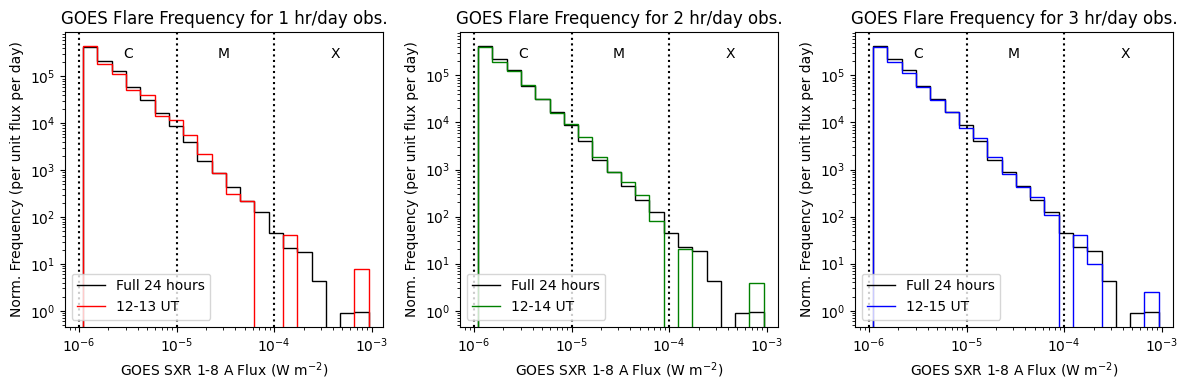

In [21]:
fig = plt.figure(figsize=(12, 4))
# Histogram for a subset of flares which have peaks within a selected UT time range
tranges = [[12, 13], [12, 14], [12, 15]]
durs = [1, 2, 3]
colors = ['r', 'g', 'b', 'orange', 'purple']
logflare_mag_subs = []
for i, trange in enumerate(tranges):
  ax = fig.add_subplot(1, 3, i+1)
  logflare_mag_sub = []
  for t, m in zip(flare_tpeak, logflare_mag):
    if (t.mjd - np.floor(t.mjd) > trange[0]/24.) and (t.mjd - np.floor(t.mjd) < trange[1]/24.):
      logflare_mag_sub.append(m)
  logflare_mag_subs.append(logflare_mag_sub)
  counts, bins = np.histogram(logflare_mag_sub, bins=20)
  bins_cen = 10. ** (bins[:-1] + np.diff(bins) / 2.)
  counts_norm = counts / bins_cen / ndays / ((trange[1]-trange[0]) / 24.)
  ax.stairs(counts_norm0, 10.**bins0, color='k', label='Full 24 hours')
  ax.stairs(counts_norm, 10.**bins, color=colors[i], label='{0:d}-{1:d} UT'.format(trange[0], trange[1]))

  ax.axvline(1e-6, ls=':', color='k')
  ax.axvline(1e-5, ls=':', color='k')
  ax.axvline(1e-4, ls=':', color='k')
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_title('GOES Flare Frequency for {0:d} hr/day obs.'.format(durs[i]))
  ax.set_xlabel(r'GOES SXR 1-8 A Flux (W m$^{-2}$)')
  ax.set_ylabel('Norm. Frequency (per unit flux per day)')
  ax.text(0.2, 0.95, 'C', ha='center', va='top', transform=ax.transAxes)
  ax.text(0.5, 0.95, 'M', ha='center', va='top', transform=ax.transAxes)
  ax.text(0.85, 0.95, 'X', ha='center', va='top', transform=ax.transAxes)
  ax.legend(loc=3)

plt.tight_layout()
